In [1]:
%pwd

'c:\\my-ml-project\\aws\\notebook'

In [2]:
import os
os.chdir("../")

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt

# Import Statistics libraries
from scipy import stats
from scipy.stats import norm

# Import Scikit-learn for Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Import country code libraries
import pycountry

#Install plotly library
import plotly.io as pio
import plotly.express as px

In [55]:
df = pd.read_csv('artifacts/data_ingestion/ds_salaries.csv')

In [56]:
df.shape

(3755, 11)

In [57]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,3755.0,2022.373635,0.691448,2020.0,2022.0,2022.0,2023.0,2023.0
salary,3755.0,190695.571771,671676.500508,6000.0,100000.0,138000.0,180000.0,30400000.0
salary_in_usd,3755.0,137570.389880,63055.625278,5132.0,95000.0,135000.0,175000.0,450000.0
remote_ratio,3755.0,46.271638,48.589050,0.0,0.0,0.0,100.0,100.0


In [59]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [60]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

**Observation:** This dataset looks clean and has no missing value.

In [61]:
df.duplicated().sum()

np.int64(1171)

**Observation:** Over half of the observations are duplicates and should be dropped.

In [62]:
df.drop_duplicates(inplace=True)

In [63]:
df.shape

(2584, 11)

In [64]:
# Retrieve distinct values exist in each variable
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}: {df[col].nunique()} distinct values")

1. work_year: 4 distinct values
2. experience_level: 4 distinct values
3. employment_type: 4 distinct values
4. job_title: 93 distinct values
5. salary: 815 distinct values
6. salary_currency: 20 distinct values
7. salary_in_usd: 1035 distinct values
8. employee_residence: 78 distinct values
9. remote_ratio: 3 distinct values
10. company_location: 72 distinct values
11. company_size: 3 distinct values


**Observation:** Few columns have a large number of categories, which will require a lot of memory to process and rare classes may not be very useful either. Hence, infrequent categories could  relabelled as 'Other'.

In [65]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [66]:
df['experience_level'].unique()

array(['SE', 'MI', 'EN', 'EX'], dtype=object)

In [67]:
# abbreviated values are replaced with full form
df['experience_level'] = df['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level'
})

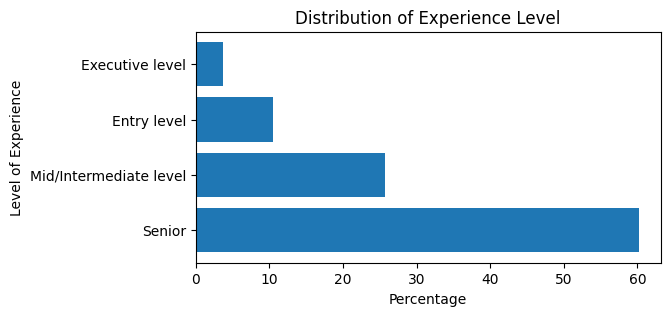

In [68]:
cat_pct = df['experience_level'].value_counts(normalize=True)*100
fig, ax = plt.subplots(figsize=(6, 3))
ax.barh(cat_pct.index, cat_pct.values)
ax.set_xlabel("Percentage")
ax.set_ylabel("Level of Experience")
ax.set_title("Distribution of Experience Level")
plt.show()

**Observation:** Over half of the observations is drawn from 'Senior' professionals and a third from 'Mid/ Intermediate' level.

In [69]:
df['employment_type'].unique()

array(['FT', 'CT', 'FL', 'PT'], dtype=object)

In [70]:
# abbreviated values are replaced with their full form
df['employment_type'] = df['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})

In [71]:
fig=px.pie(df.groupby(
    'employment_type',
    as_index=False).count().sort_values(by='salary_in_usd',
                                          ascending=False),
                                          names='employment_type',
                                          values='salary_in_usd',
                                          color='employment_type',
                                          hole=0.7,
                                          labels={'employment_type':'Employment level',
                                                  'salary_in_usd':'count'},
                                          template='seaborn',
                                          title='<b> Employment Types Proportion')
fig.update_layout(title_x=0.5)

**Observation:** 99% of the samples is drawn from 'Full-time' employees.

In [72]:
df['job_title'].nunique()

93

**Observation:** The number of 'job-title' is as high as 347 which is neither necessary nor practical for ML model training. Hence, 'job_title' values are re-groped in to 10 broader job categories by putting similar job roles into same category.  

In [73]:
def regroup_job_titles(job_title):
    bi_analyst = ['BI Data Analyst', 
        'Business Data Analyst', 'BI Developer', 'BI Analyst', 'Business Intelligence Engineer', 
        'BI Data Engineer', 'Business Intelligence Analyst','Power BI Developer', 
        'Business Intelligence Developer', 'Business Intelligence', 'BI Engineer']
    data_analyst = [
        'Analyst','Data Analyst', 'Data Quality Analyst', 'Product Data Analyst', 
        'Data Analytics Lead', 'Data Lead', 'Finance Data Analyst', 'Insight Analyst', 
        'Lead Data Analyst', 'Financial Data Analyst', 'Staff Data Analyst', 
        'Compliance Data Analyst', 'Data Analytics Engineer', 'Data Operations Analyst', 
        'Data Analytics Lead', 'Data Analytics Specialist', 'Data Analytics Consultant', 
        'Marketing Data Analyst', 'Principal Data Analyst', 'Data Management Analyst', 
        'Quantitative Analyst', 'Data Reporting Analyst']
    data_scientist = [
        'Data Scientist', 'Applied Scientist', 'Research Scientist', 'Lead Data Scientist',
        '3D Computer Vision Researcher', 'Deep Learning Researcher', 'Staff Data Scientist', 
        'Data Science Lead', 'Data Science Consultant', 'Product Data Scientist', 
        'Data Science Tech Lead','Applied Data Scientist', 'Principal Data Scientist', 
        'Data Science Engineer', 'Data Modeler', 'Decision Scientist']
    
    ai_engineer = [
        'AI/Computer Vision Engineer', 'Computer Vision Software Engineer', 'AI Scientist', 
        'AI Programmer', 'AI Developer', 'Computer Vision Engineer', 'AI Architect', 
        'Deep Learning Engineer', 'AI Specialist']
    
    ml_engineer = [
        'Machine Learning Engineer', 'ML Engineer', 'Lead Machine Learning Engineer',
        'Principal Machine Learning Engineer', 'Machine Learning Scientist',
        'MLOps Engineer', 'NLP Engineer','Applied Machine Learning Scientist', 
        'Machine Learning Software Engineer', 'Applied Machine Learning Engineer', 
        'Machine Learning Developer', 'Machine Learning Infrastructure Engineer']
    
    data_engineer = [
        'Data Engineer', 'ETL Developer', 'Big Data Engineer', 'Azure Data Engineer',
        'Lead Data Engineer', 'Analytics Engineer', 'Data Operations Engineer',
        'Cloud Data Engineer', 'Marketing Data Engineer', 'ETL Engineer',
        'Principal Data Engineer', 'Software Data Engineer', 'Software Data Engineer',
        'Cloud Database Engineer', 'Data DevOps Engineer', 'Data Architect', 'Data Integration Engineer',
        'Big Data Architect', 'Data Infrastructure Engineer', 'Cloud Data Architect', 
        'Cloud Data Architect', 'Principal Data Architect', 'Architect', 'Data Developer']

    executive = [
        'Head of Data', 'Data Science Manager', 'Director of Data Science', 'Manager',
        'Head of Data Science', 'Data Scientist Lead', 'Head of Machine Learning', 
        'Manager Data Management', 'Data Analytics Manager', 'Data Manager', 
        'Data Specialist', 'Data Management Specialist', 'Engineering Manager', 
        'Data Lead', 'Data Strategist', 'Machine Learning Manager', 'Technical Lead', 
        'Analytics Lead', 'Data Governance Lead', 'Lead Engineer']
    
    ai_ml_researcher = [
        'Machine Learning Researcher', 'Machine Learning Research Engineer',
        'Research Engineer', 'Research Analyst', 'AI Researcher']
    
    soft_engineer = [
        'Software Engineer', 'Software Development Engineer' , 'Developer', 
        'Software Developer', 'DevOps Engineer', 'Solution Architect', 'Backend Engineer',
        'Solutions Engineer', 'Full Stack Engineer', 'Solutions Architect',
        'Full Stack Developer']

    it_engineer = [
        'Engineer', 'Systems Engineer', 'Platform Engineer', 'Site Reliability Engineer',
        'Cloud Engineer'],
    
    other_data_prof = [
        'Data Product Manager', 'Data Governance', 'Data Governance Analyst', 'Data Product Owner',

    ]
    
    if job_title in data_scientist:
        return "Data Scientist"
    elif job_title in bi_analyst:
        return "BI Analyst"
    elif job_title in ml_engineer:
        return "ML Engineer"
    elif job_title in data_engineer:
        return "Data Engineer"
    elif job_title in executive:
        return "AI/ DS Executive"
    elif job_title in data_analyst:
        return "Data Analyst"
    elif job_title in ai_engineer:
        return "AI Engineer"
    elif job_title in ai_ml_researcher:
        return "AI/ ML Researcher"
    elif job_title in soft_engineer:
        return "Software Engineer"
    elif job_title in it_engineer:
        return "IT Engineer"
    elif job_title in other_data_prof:
        return "Other Data Profession"
    else:
        return job_title

# Apply the function to the 'job_title' column and create a new column 'job_category'
df['job_title_trans'] = df['job_title'].apply(regroup_job_titles)

In [74]:
df['job_title_trans'].value_counts().head(25)

job_title_trans
Data Engineer                    810
Data Scientist                   707
Data Analyst                     439
ML Engineer                      323
AI/ DS Executive                 147
AI Engineer                       58
BI Analyst                        56
AI/ ML Researcher                 42
Autonomous Vehicle Technician      2
Name: count, dtype: int64

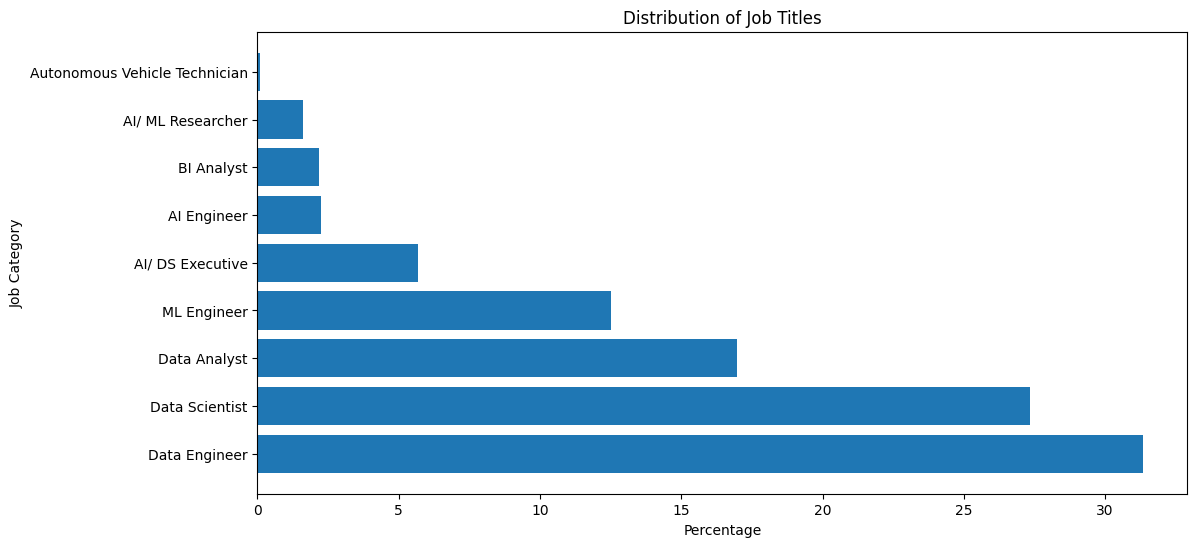

In [75]:
value_counts = df['job_title_trans'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(10, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Distribution of Job Titles')
plt.show()

In [76]:
df['job_title_trans'].nunique()

9

**Observation:** Even after regrouping there 234 unique categories of job titles with many categories have a frequency ranging from 1 to 500, i.e. less than 1% of cumulative frequency. 

In [77]:
from typing import Literal

def feature_engineer(df: pd.DataFrame, 
                     old_feature: str = None,
                     new_feature: str = None,
                     option: Literal['top_n', 'threshold'] = 'top_n',
                     top_n: int = 5,
                     threshold: int =100):
    if option == 'top_n':
        top_cat_index = df[old_feature].value_counts().nlargest(top_n).index
    elif option == 'threshold':
        freq_arr = df[old_feature].value_counts()
        top_cat_index = freq_arr[freq_arr >= threshold].index
    else:
        raise ValueError(f"Didn't choose an option from ['top_n', 'threshold']")
        
    df[new_feature] = df[old_feature].apply(
        lambda x: 'Other' if x not in top_cat_index else x)
    return df

In [136]:
# Top 8 job titles are picked and regmaining are categorised as 'Other'
df = feature_engineer(df, 
                      old_feature='job_title_trans',
                      new_feature='job_title_top',
                      option='top_n',
                      top_n=8)
df['job_title_top'].value_counts()

job_title_top
Data Engineer        810
Data Scientist       707
Data Analyst         439
ML Engineer          323
AI/ DS Executive     147
AI Engineer           58
BI Analyst            56
AI/ ML Researcher     42
Other                  2
Name: count, dtype: int64

In [80]:
df['employee_residence'].nunique()

78

In [81]:
print(df['company_location'].nunique())

72


In [82]:
# Convert ISO 3166 country code to country name
def country_code_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None  # Use None so it can be safely skipped later if needed

In [83]:
df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

In [84]:
# Step 1: Group your data
avg_salary_by_location = (
    df.groupby('company_location', as_index=False)['salary_in_usd'].mean()
)

# Step 2: Convert country names to ISO Alpha-3
def name_to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        return None  # Skips invalid names like 'Remote'

# Apply conversion
avg_salary_by_location['iso_alpha'] = avg_salary_by_location['company_location'].apply(name_to_iso3)

# Drop rows with invalid or unrecognized country names
avg_salary_by_location = avg_salary_by_location.dropna(subset=['iso_alpha'])

# Step 3: Create the choropleth
fig = px.choropleth(
    avg_salary_by_location,
    locations='iso_alpha',                  # Use ISO Alpha-3 here
    color='salary_in_usd',
    hover_name='company_location',
    color_continuous_scale='Plasma',
    title='Average Salary by Company Location',
    labels={'salary_in_usd': 'Average Salary (USD)'},
    projection='equirectangular'
)

fig.update_layout(title_x=0.5)
fig.show()

In [85]:
df['remote_ratio'].value_counts()

remote_ratio
100    1211
0      1186
50      187
Name: count, dtype: int64

In [87]:
df['remote_ratio'] = df['remote_ratio'].astype(str)
df['remote_ratio'] = df['remote_ratio'].replace(
    {'0': 'On-site',
     '50': 'Hybrid',
     '100': 'Remote'}
)
df['remote_ratio'].value_counts()

remote_ratio
On-site/ Hybrid    1373
Remote             1211
Name: count, dtype: int64

In [88]:
df['company_size'] = df['company_size'].replace(
    {'L': 'Large',
    'M': 'Medium',
    'S': 'Small'}
)

In [89]:
df['company_size'].value_counts()

company_size
Medium    2028
Large      409
Small      147
Name: count, dtype: int64

In [90]:
df['employee_residence'].value_counts().head(15)

employee_residence
United States     1893
United Kingdom     150
Canada              81
India               70
Germany             47
Spain               47
France              37
Portugal            18
Brazil              18
Netherlands         15
Greece              13
Australia           11
Mexico              10
Pakistan             8
Italy                8
Name: count, dtype: int64

In [91]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_trans,job_title_top
0,2023,Senior,Full-time,Principal Data Scientist,80000,EUR,85847,Spain,Remote,Spain,Large,Data Scientist,Data Scientist
1,2023,Mid/Intermediate level,Contractor,ML Engineer,30000,USD,30000,United States,Remote,United States,Small,ML Engineer,ML Engineer
2,2023,Mid/Intermediate level,Contractor,ML Engineer,25500,USD,25500,United States,Remote,United States,Small,ML Engineer,ML Engineer
3,2023,Senior,Full-time,Data Scientist,175000,USD,175000,Canada,Remote,Canada,Medium,Data Scientist,Data Scientist
4,2023,Senior,Full-time,Data Scientist,120000,USD,120000,Canada,Remote,Canada,Medium,Data Scientist,Data Scientist


In [138]:
# residences other than top 5 are re-labelled as 'other'
df = feature_engineer(df, old_feature='employee_residence', 
                      new_feature='employee_residence_top', option='top_n',
                      top_n=7)

df['employee_residence_top'].value_counts()

employee_residence_top
United States     1893
Other              259
United Kingdom     150
Canada              81
India               70
Spain               47
Germany             47
France              37
Name: count, dtype: int64

In [95]:
df['company_location'].nunique()

72

In [96]:
df['company_location'].value_counts().head(10)

company_location
United States     1929
United Kingdom     155
Canada              83
India               57
Germany             55
Spain               44
France              33
Brazil              15
Australia           14
Portugal            14
Name: count, dtype: int64

In [142]:
df = feature_engineer(df, old_feature='company_location',
                      new_feature='company_location_top',
                      option='top_n',
                      top_n=7)
df['company_location_top'].value_counts()

company_location_top
United States     1929
Other              228
United Kingdom     155
Canada              83
India               57
Germany             55
Spain               44
France              33
Name: count, dtype: int64

In [98]:
df['work_year'].value_counts()

work_year
2023    1156
2022    1125
2021     228
2020      75
Name: count, dtype: int64

In [99]:
# Number of entries where salary currency USD but company location is NOT USA
df[(df['salary_currency']=='USD') & (df['company_location']!=
                                     'United States')]['company_location_top'].count()

np.int64(186)

In [100]:
def adjust_salary(data:pd.DataFrame):
    year = data['work_year']
    country = data['company_location']
    salary_usd = data['salary_in_usd']
    # Inflation rates
    us_inflation_rates = {2019: 0.018, 2020: 0.012, 2021: 0.047, 
                        2022: 0.08, 2023: 0.041, 2024: 0.029, 2025: 0.02}
    global_inflation_rates = {2019: 0.019, 2020: 0.019, 2021: 0.035, 
                            2022: 0.057, 2023: 0.049, 2024: 0.058, 2025: 0.036}
    adjsuted_salary = salary_usd
    if country == 'United States':
        inflation_rates = us_inflation_rates
    else:
        inflation_rates = global_inflation_rates
    for yr in range(year, 2025):
        inflation_rate = inflation_rates[yr]
        adjsuted_salary *= (1+inflation_rate)
    adjsuted_salary = int(round(adjsuted_salary, 0))

    return adjsuted_salary
df['inflation_adj_salary'] = df.apply(adjust_salary, axis=1)


In [101]:
def create_box_plot(df:pd.DataFrame, *, x_val:str, y_val:str, x_label:str, 
                    y_label:str="Salaries", 
                    chart_title:str="Inflation adjusted salaries"):

    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=x_val, y=y_val)
    plt.title(chart_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if df[x_val].nunique() >= 5:
        plt.xticks(rotation=45, ha='right')
    plt.show()

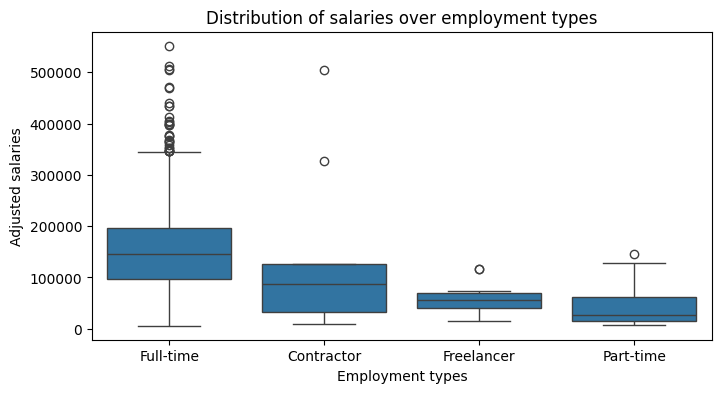

In [102]:
create_box_plot(df, x_val='employment_type', y_val='inflation_adj_salary',
                x_label='Employment types', y_label='Adjusted salaries',
                chart_title='Distribution of salaries over employment types')

**Observation:** both 'salary' and 'salary_in_usd' provide similar information and 'salary_currency' seems irrelevant. Hence, 'salary' and 'salary_currency' could better be dropped from the data frame, whereas 'salary_in_usd' is selected as the target variable. 

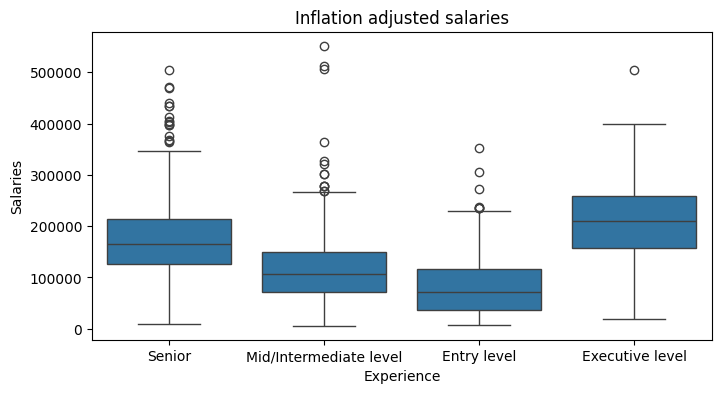

In [103]:
create_box_plot(df=df, x_val='experience_level', y_val='inflation_adj_salary',
                x_label='Experience', y_label='Salaries')

In [104]:
def create_proba_plot(df:pd.DataFrame, columns:list = []):

    # Loop over the columns and plot the distribution of each variable
    for col in columns:
        # Plot the distribution of the data
        sns.histplot(df[col], kde=True)

        # Fit a normal distribution to the data
        (mu, sigma) = stats.norm.fit(df[col])
        print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

        # Calculate the skewness and kurtosis of the data
        print('{}: Skewness: {:.2f}'.format(col, df[col].skew()))
        print('{}: Kurtosis: {:.2f}'.format(col, df[col].kurt()))

        # Add the fitted normal distribution to the plot
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        y = stats.norm.pdf(x, mu, sigma)
        plt.plot(x, y, label='Normal fit')

        # Add labels and title to the plot
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title('Distribution of {}'.format(col))

        # Plot the QQ-plot
        fig = plt.figure()
        stats.probplot(df[col], plot=plt)

    plt.show()

salary_in_usd: mu = 133409.28, sigma = 67123.85
salary_in_usd: Skewness: 0.62
salary_in_usd: Kurtosis: 0.83


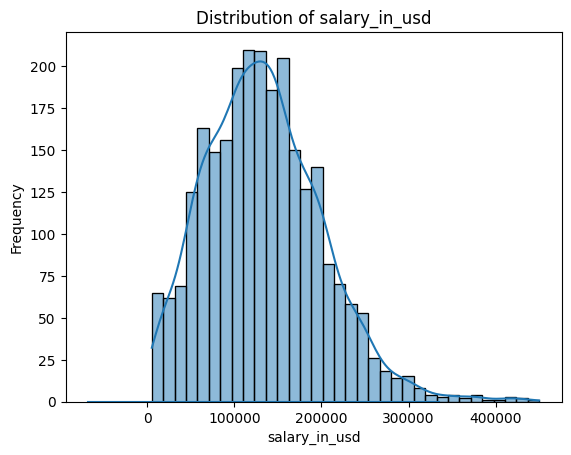

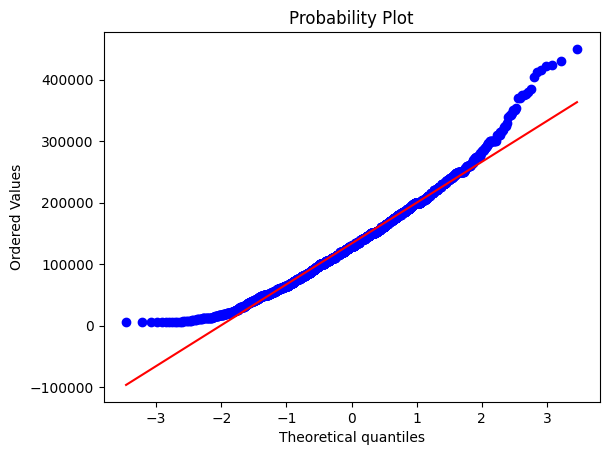

In [105]:
create_proba_plot(df=df, columns=['salary_in_usd'])

In [106]:
def remove_salary_outliers(df: pd.DataFrame) -> pd.DataFrame:
    q1 = df['inflation_adj_salary'].quantile(0.25)
    q3 = df['inflation_adj_salary'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
        
    return df[(df['inflation_adj_salary'] >= lower_bound) & 
              (df['inflation_adj_salary'] <= upper_bound)]

# Example usage:
df_outlier_free = remove_salary_outliers(df)

In [107]:
df.shape[0] - df_outlier_free.shape[0]

32

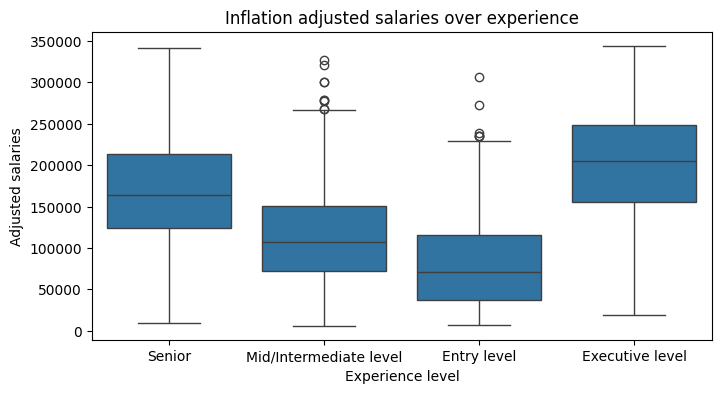

In [108]:
create_box_plot(df_outlier_free, x_val='experience_level', y_val='inflation_adj_salary',
                chart_title='Inflation adjusted salaries over experience',
                x_label='Experience level', y_label='Adjusted salaries')

inflation_adj_salary: mu = 146546.92, sigma = 68899.82
inflation_adj_salary: Skewness: 0.25
inflation_adj_salary: Kurtosis: -0.41


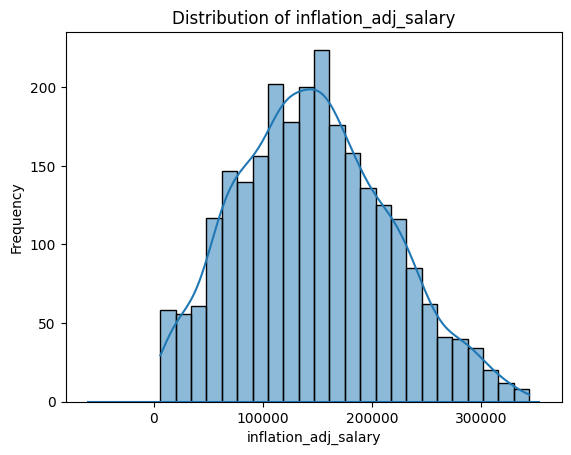

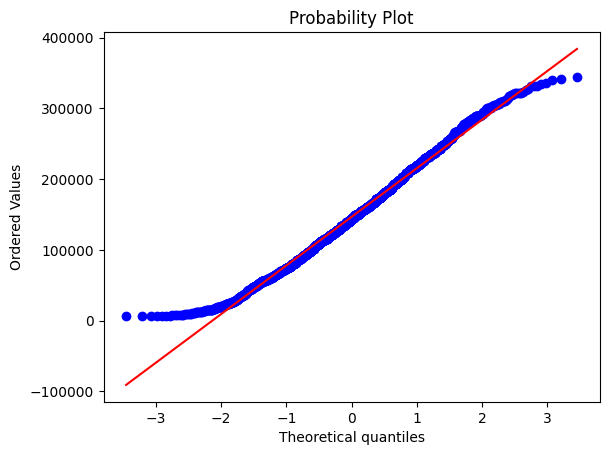

In [109]:
create_proba_plot(df=df_outlier_free, columns=['inflation_adj_salary'])

In [111]:
df_outlier_free.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'job_title_trans',
       'job_title_top', 'employee_residence_top', 'company_location_top',
       'inflation_adj_salary'],
      dtype='object')

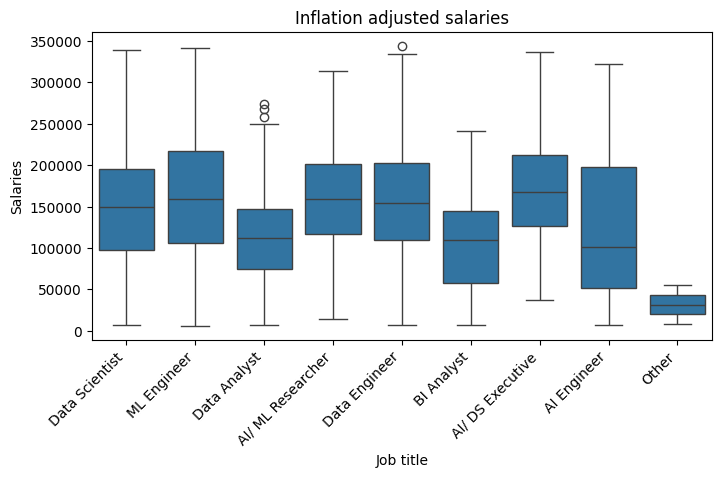

In [113]:
create_box_plot(df_outlier_free, x_val='job_title_top', y_val='inflation_adj_salary', 
                x_label='Job title')

In [ ]:
df_job_type = df_outlier_free[~df_outlier_free['job_title_top'].isin(['Other'])]

inflation_adj_salary: mu = 146637.12, sigma = 68848.26
inflation_adj_salary: Skewness: 0.25
inflation_adj_salary: Kurtosis: -0.41


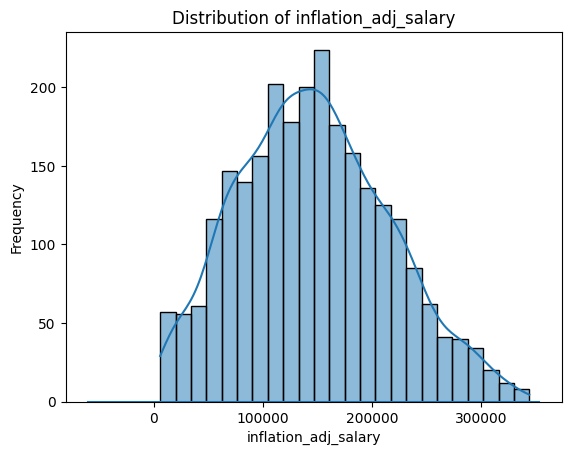

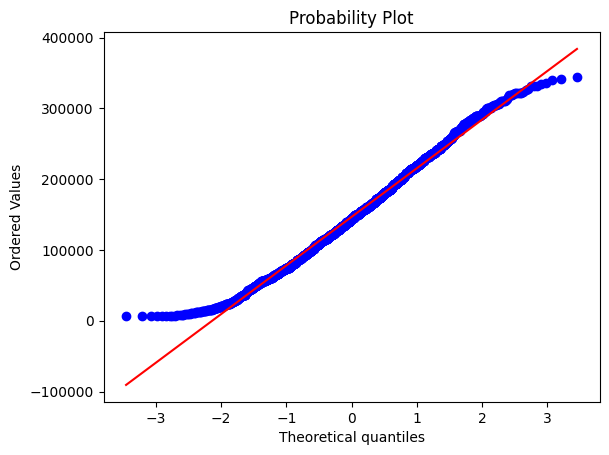

In [119]:
create_proba_plot(df_job_type, columns=['inflation_adj_salary'])

<Axes: xlabel='inflation_adj_salary', ylabel='Count'>

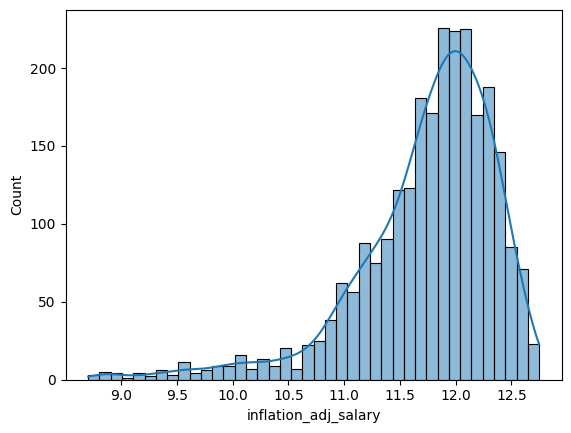

In [122]:
sns.histplot(np.log1p(df_job_type['inflation_adj_salary']), kde=True)

C:\Users\abdul\AppData\Local\Temp\ipykernel_24232\2217814777.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




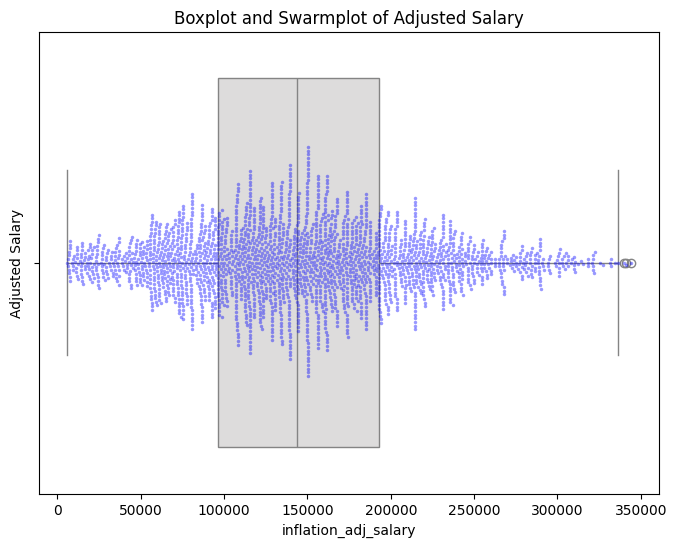

,inflation_adj_salary
count,2550.00
mean,146637.12
std,68861.77
min,6020.00
25%,96220.25
50%,143933.50
75%,193113.00
max,344173.00


In [129]:
# apply formatting to describe method for 'adjusted_salary' column
formatted_data = df_job_type.loc[:, 'inflation_adj_salary'].describe().apply(lambda x: f'{x:.2f}')

# create boxplot and swarmplot for 'adjusted_salary' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_job_type['inflation_adj_salary'], palette='coolwarm')
sns.swarmplot(x=df_job_type['inflation_adj_salary'], color='blue', alpha=0.4, size=2.5)
plt.ylabel('Adjusted Salary')
plt.title('Boxplot and Swarmplot of Adjusted Salary')
plt.show()

# apply styling to formatted data
styled_data = formatted_data.to_frame().style \
    .background_gradient(cmap='Blues') \
    .set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# display styled data
display(styled_data)

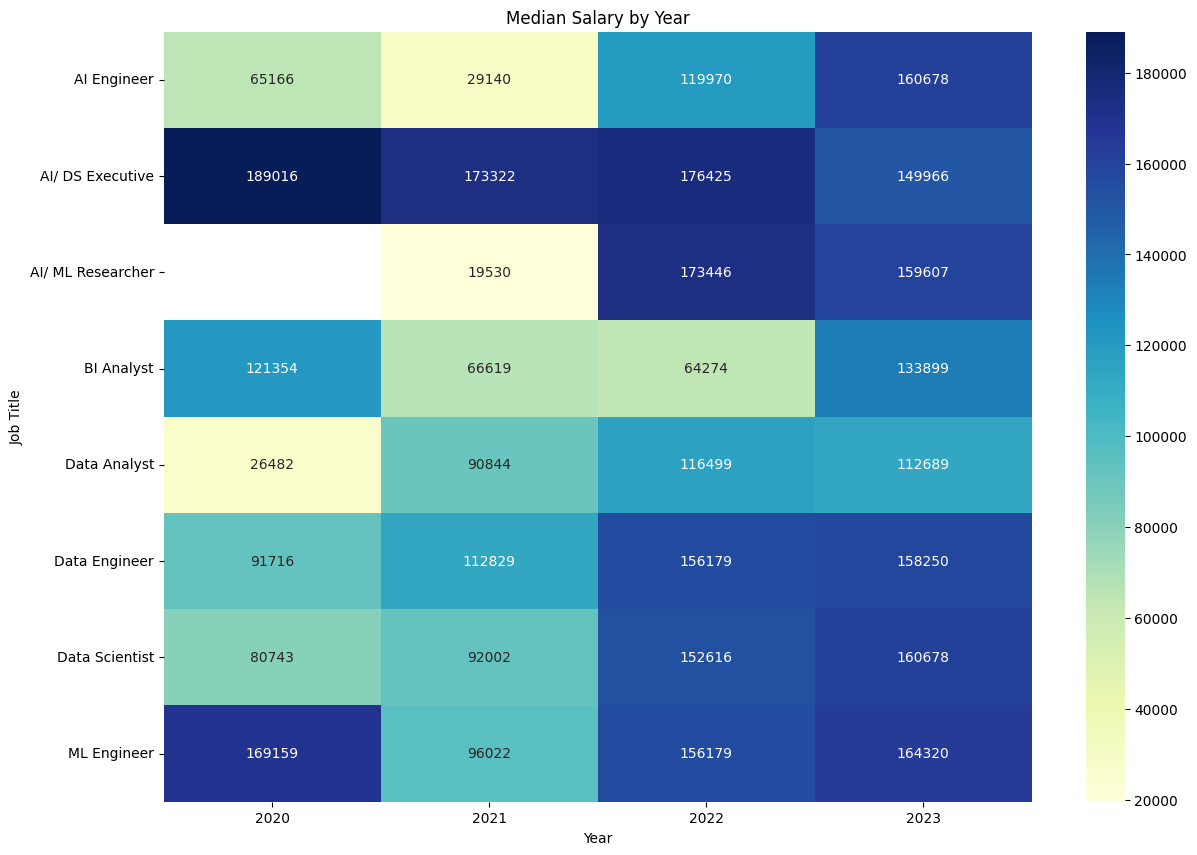

In [124]:
df_copy = df_job_type.copy(deep=True)

#  Median salary by job title
pivot_table = df_copy.pivot_table(values='inflation_adj_salary', index='job_title_top',
                                   columns='work_year', aggfunc='median')
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Median Salary by Year')
plt.xlabel('Year')
plt.ylabel('Job Title')
plt.show()

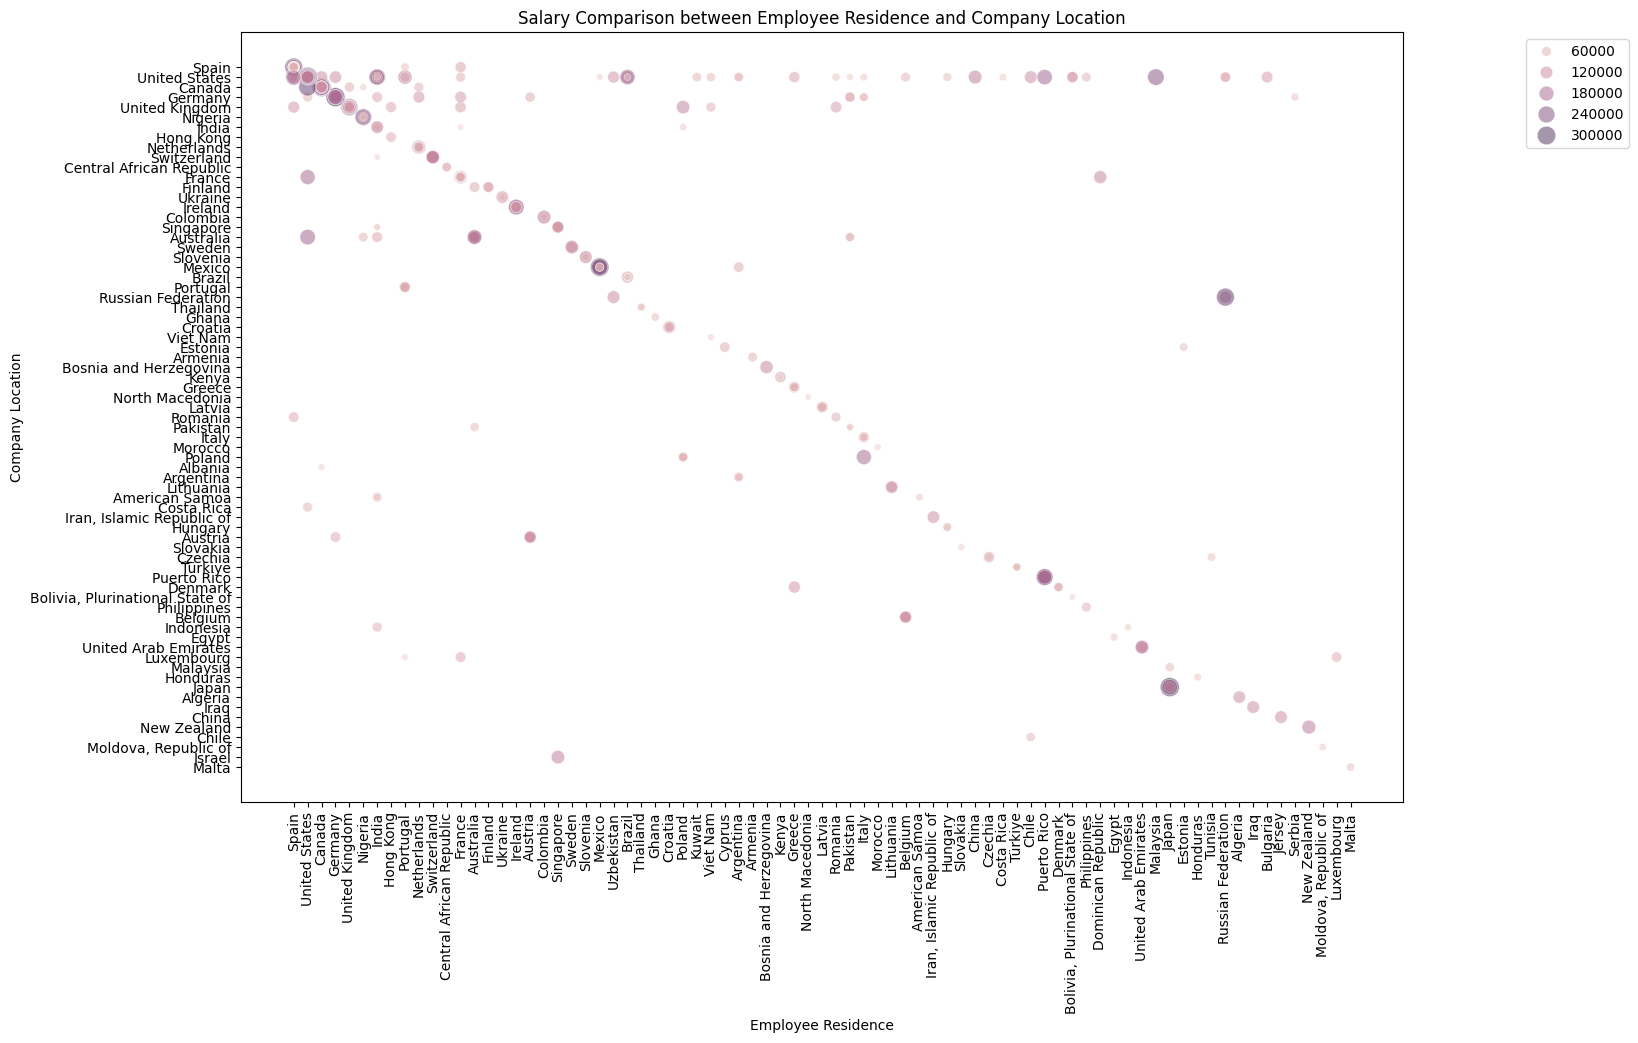

In [125]:
# Salary comparison between employee residence and company location
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_copy, x='employee_residence', y='company_location', 
                hue='inflation_adj_salary', size='inflation_adj_salary', 
                sizes=(20, 200), alpha=0.5)
plt.title('Salary Comparison between Employee Residence and Company Location')
plt.xlabel('Employee Residence')
plt.ylabel('Company Location')
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()